In [1]:
import argparse
import json

import torchvision.transforms as transforms

from models import *
from utils import pil_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def caption_image(encoder, generator, image_path, word_index, index_word, beam_size=5):

    vocab_size = len(word_index)

    img = pil_loader(image_path)

    img = data_transforms(img)

    img = torch.FloatTensor(img).to(device)

    img = img.unsqueeze(0)
    img_feats = encoder(img)

    img_feats = img_feats.expand(beam_size, img_feats.shape[1], img_feats.shape[-1])

    prev_words = torch.LongTensor([[word_index['<start>']]] * beam_size).to(device)

    sents = prev_words
    top_preds = torch.zeros(beam_size, 1).to(device)
    alphas = torch.ones(beam_size, 1, img_feats.size(1)).to(device)

    completed_sents = []
    completed_sents_alphas = []
    completed_sents_preds = []

    step = 1

    hidden_state = generator.init_hidden_state(img_feats)

    while True:
        embedding = generator.embedding(prev_words).squeeze(1)
        context, alpha = generator.attention_net(img_feats, hidden_state)
        gate = generator.sigmoid(generator.f_beta(hidden_state))
        context = gate * context

        input_word = torch.cat((embedding, context), dim=1)
        hidden_state = generator.gru(input_word, hidden_state)

        preds = generator.fc(hidden_state)
        preds = F.log_softmax(preds, dim=1)

        preds = top_preds.expand_as(preds) + preds

        if step == 1:
            top_preds, top_words = preds[0].topk(beam_size, 0, True, True)
        else:
            top_preds, top_words = preds.view(-1).topk(beam_size, 0, True, True)

        prev_word_ids = top_words // vocab_size
        next_word_ids = top_words % vocab_size

        sents = torch.cat([sents[prev_word_ids], next_word_ids.unsqueeze(1)], dim=1)

        alphas = torch.cat([alphas[prev_word_ids], alpha[prev_word_ids].unsqueeze(1)], dim=1)

        incomplete = [idx for idx, next_word in enumerate(next_word_ids) if next_word != word_index['<end>']]
        complete = list(set(range(len(next_word_ids))) - set(incomplete))

        if len(complete) > 0:
            completed_sents.extend(sents[complete].tolist())
            completed_sents_alphas.extend(alphas[complete].tolist())
            completed_sents_preds.extend(top_preds[complete])
        beam_size -= len(complete)

        if beam_size == 0:
            break
        sents = sents[incomplete]
        alphas = alphas[incomplete]
        hidden_state = hidden_state[prev_word_ids[incomplete]]
        img_feats = img_feats[prev_word_ids[incomplete]]
        top_preds = top_preds[incomplete].unsqueeze(1)
        prev_words = next_word_ids[incomplete].unsqueeze(1)

        if step > 50:
            break
        step += 1

    idx = completed_sents_preds.index(max(completed_sents_preds))
    sentence = completed_sents[idx]
    alpha = completed_sents_alphas[idx]

    for w in sentence:
        print(index_word[str(w)], end=' ')


def greedy_caption_image(encoder, generator, image_path, word_index, index_word):
    vocab_size = len(word_index)

    img = pil_loader(image_path)

    img = data_transforms(img)

    img = torch.FloatTensor(img).to(device)

    img = img.unsqueeze(0)
    img_feats = encoder(img)

    i = 0
    input_word = torch.LongTensor([[word_index['<start>']]]).to(device)

    hidden_state = generator.init_hidden_state(img_feats)

    while i < 20:
        embedding = generator.embedding(input_word).squeeze(1)
        context, alpha = generator.attention_net(img_feats, hidden_state)
        input_w = torch.cat((embedding, context), dim=1)
        hidden_state = generator.gru(input_w, hidden_state)
        preds = generator.fc(hidden_state)
        input_word = torch.topk(preds, 1)[1]
        print(index_word[str(input_word.item())], end=' ')
#         if index_word[str(input_word.item())] == '<end>':
#             break
        i += 1

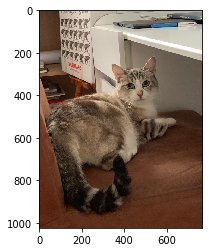

<start> a couple of cats are sitting on a couch <end> 

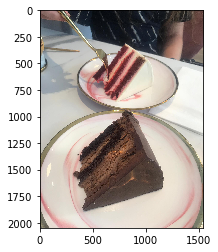

<start> a piece of cake sitting on top of a white plate <end> 

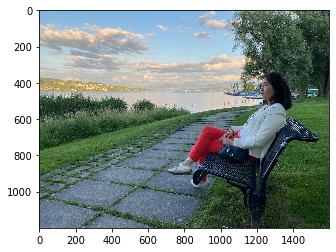

<start> a woman sitting on a bench in a park <end> 

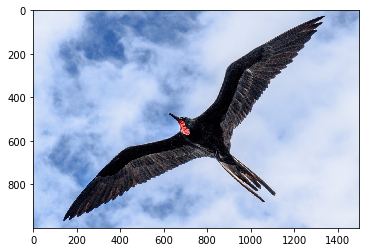

<start> a couple of birds flying in the air <end> 

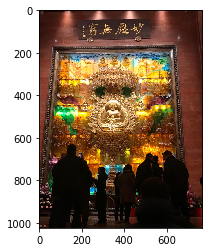

<start> a crowd of people standing around a building <end> 

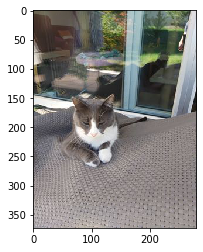

<start> a black and white cat sitting on a white chair <end> 

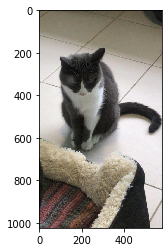

<start> a black and white cat laying on a bed <end> 

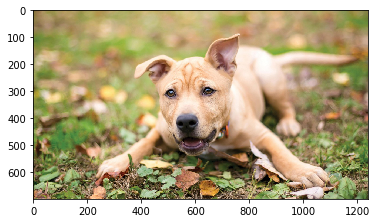

<start> a large brown dog sitting on top of a green field <end> 

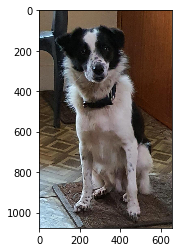

<start> a black and white dog sitting on a bench <end> 

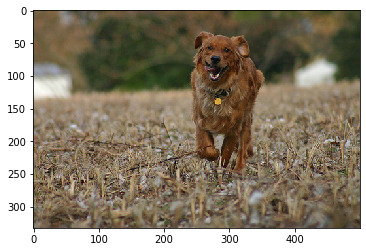

<start> a large brown dog standing on top of a field <end> 

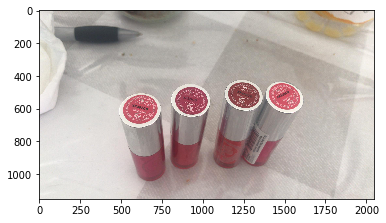

<start> a pair of scissors sitting on top of a table <end> 

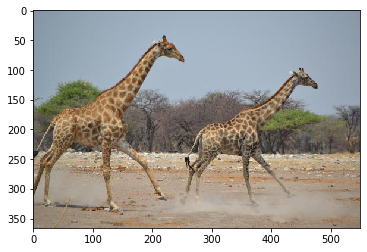

<start> a couple of giraffe standing next to each other <end> 

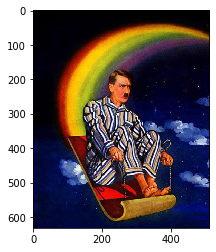

<start> a man is doing a trick on a skateboard <end> 

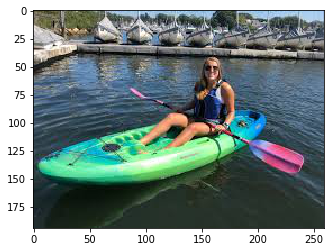

<start> a group of people on surfboards in the water <end> 

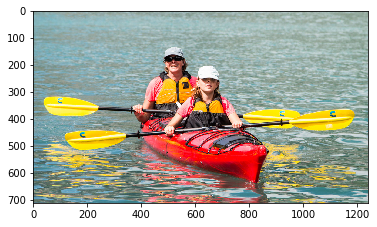

<start> a couple of people that are in the water <end> 

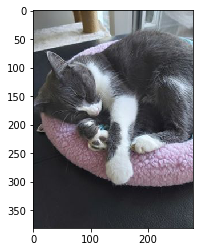

<start> a black and white cat sitting on a blue chair <end> 

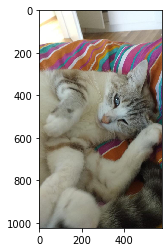

<start> a couple of cats are sitting on a couch <end> 

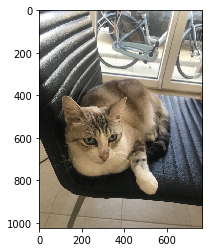

<start> a cat sitting on top of a blue chair <end> 

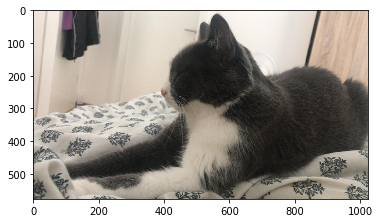

<start> a black and white cat sitting on a couch <end> 

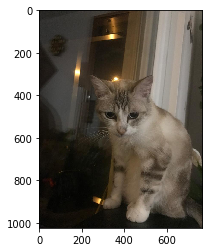

<start> a white and black cat sitting on top of a table <end> 

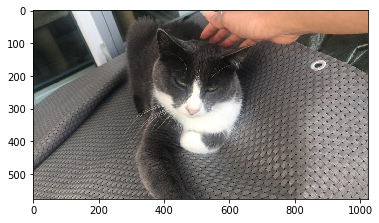

<start> a black cat sitting on a white chair <end> 

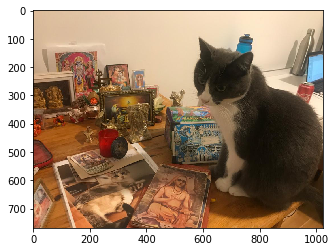

<start> a cat sitting on top of a wooden table <end> 

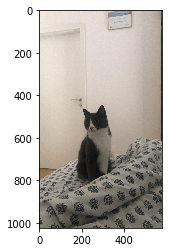

<start> a black and white cat sitting on a bed <end> 

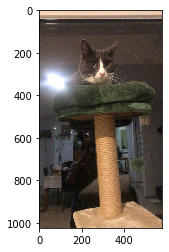

<start> a cat sitting on top of a wooden table <end> 

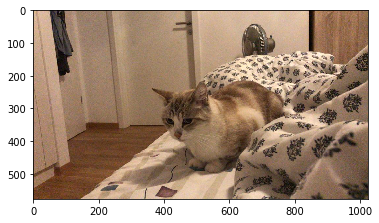

<start> a cat laying on a bed in a room <end> 

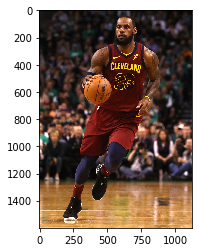

<start> a group of young men playing a game of basketball <end> 

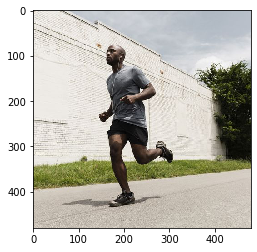

<start> a man riding a skateboard down a street <end> 

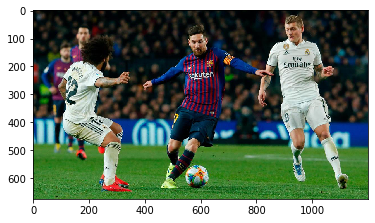

<start> a group of young men playing a game of soccer <end> 

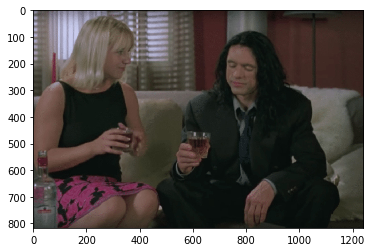

<start> a group of people sitting around a table <end> 

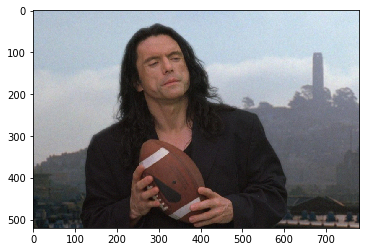

<start> a man and a woman standing next to each other <end> 

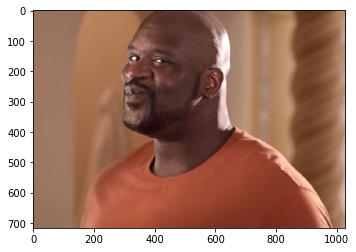

<start> a man holding a nintendo wii game controller <end> 

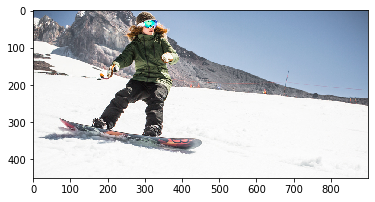

In [ ]:
with open('.' + '/processed_data/' + 'coco' + '/word_index.json') as f:
    word_index = json.load(f)

with open('.' + '/processed_data/' + 'coco' + '/index_word.json') as f:
    index_word = json.load(f)

generator = Generator(attention_dim=512, gru_units=512,
                      embedding_dim=512, vocab_size=len(word_index))

encoder = Encoder('resnet152')
encoder.to(device)

checkpoint = torch.load('./ckpts/coco/gen/mle_gen_resnet152_13.pth')
generator.load_state_dict(checkpoint['gen_state_dict'])
generator.to(device)

generator.eval()

encoder.eval()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./test_images') if isfile(join('./test_images', f))]

for f in onlyfiles:
    with torch.no_grad():
        img=mpimg.imread('./test_images/' + f)
        imgplot = plt.imshow(img)
        plt.show()
        if False:
            greedy_caption_image(encoder=encoder, generator=generator, image_path='./test_images/' + f,
                                 word_index=word_index, index_word=index_word)
        else:
            caption_image(encoder, generator, './test_images/' + f, word_index, index_word, beam_size=10)